<a href="https://colab.research.google.com/github/soyJung/UHI-Morphology/blob/main/UrbanMorpho_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### geo_em.mod.nc 파일을 읽어 도시 모양을 수정
1. 남쪽 해안을 따라 도시가 존재하는 경우: geo_em.10.nc
2. 동쪽 해안을 따라 도시가 존재하는 경우: geo_em.11.nc

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install -y libproj-dev proj-data proj-bin libgeos-dev
!pip install Cartopy netcdf4 scikit-image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgeos-dev is already the newest version (3.12.1-1~jammy0).
libgeos-dev set to manually installed.
libproj-dev is already the newest version (9.3.1-1~jammy0).
libproj-dev set to manually installed.
proj-data is already the newest version (9.3.1-1~jammy0).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 205 kB of archives.
After this operation, 521 kB of additional disk space will be used.
Get:1 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 proj-bin amd64 9.3.1-1~jammy0 [205 kB]
Fetched 205 kB in 1s (187 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 126435 files and directories currently installed.)
Preparing to unpack .../proj-bin_9.3.1-1~jammy0_amd64.deb ...
Unpacking proj-bin (9.3.1-1~jammy0) ...
Setting up proj

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#import cartopy.feature as cfeature
from skimage.morphology import convex_hull_image
from skimage.measure import regionprops
from scipy.ndimage import binary_erosion

In [8]:
# LU_INDEX를 그리는 함수
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

def plot_map(ds,title="LU Index",cmap="GnBu"):
    """
    데이터셋(ds)을 받아 지도에 pcolormesh를 그리는 함수입니다.

    Args:
        ds (xarray.Dataset): 'CLAT', 'CLONG', 'LU_INDEX' 변수를 포함하는 데이터셋.
        title (str, optional): 그래프의 제목. 기본값은 "Map".
        cmap (str, optional): 사용할 색상 맵. 기본값은 "GnBu".
    """
    # 1. 데이터 추출
    lat = ds["CLAT"].isel(Time=0)
    lon = ds["CLONG"].isel(Time=0)
    data_to_plot = ds["LU_INDEX"].isel(Time=0)

    # 2. 지도 투영법 설정 (Lambert Conformal)
    lambert = ccrs.LambertConformal(
        central_longitude=128.93,
        central_latitude=35.43,
        standard_parallels=(30.0, 60.0)
    )

    # 3. 그림 및 축 생성
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=lambert)

    # 4. 데이터 그리기 (pcolormesh)
    mesh = ax.pcolormesh(
        lon, lat, data_to_plot,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        shading="nearest"
    )

    # 5. 지도의 표시 영역 설정
    ax.set_extent([float(lon.min()), float(lon.max()),
                     float(lat.min()), float(lat.max())],
                    crs=ccrs.PlateCarree())

    # 6. 경위도 격자 및 라벨 설정
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linestyle="--",
        linewidth=0.5,
        color="gray"
    )
    gl.top_labels = False
    gl.right_labels = False
    gl.x_inline = False
    gl.y_inline = False
    gl.xlabel_style = {"size": 10, "color": "black"}
    gl.ylabel_style = {"size": 10, "color": "black"}

    # 7. 제목 설정 및 출력
    plt.title(title)
    plt.show()

<xarray.Dataset> Size: 355kB
Dimensions:   (Time: 1, south_north: 149, west_east: 149)
Coordinates:
    CLAT      (Time, south_north, west_east) float32 89kB ...
    CLONG     (Time, south_north, west_east) float32 89kB ...
Dimensions without coordinates: Time, south_north, west_east
Data variables:
    Times     (Time) |S19 19B ...
    LANDMASK  (Time, south_north, west_east) float32 89kB ...
    LU_INDEX  (Time, south_north, west_east) float32 89kB ...
Attributes:
    creation_date:  Thu Aug 28 12:12:33 KST 2025
    Conventions:    None
    source_file:    /home/syjung2024/2024_Spring/IdealUHI/EXP17/WPS-org/geo_e...
    title:          NCL Simple Approach to netCDF Creation


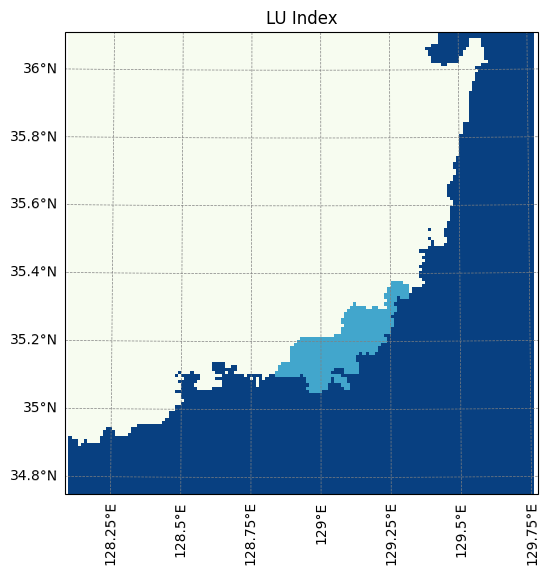

In [9]:
f = '/content/drive/MyDrive/UHI/geo_em.mod.nc'
ds = xr.open_dataset(f)

# CLAT과 CLONG을 데이터 변수에서 좌표로 변경합니다.
ds = ds.set_coords(['CLAT', 'CLONG'])
print(ds)

plot_map(ds)

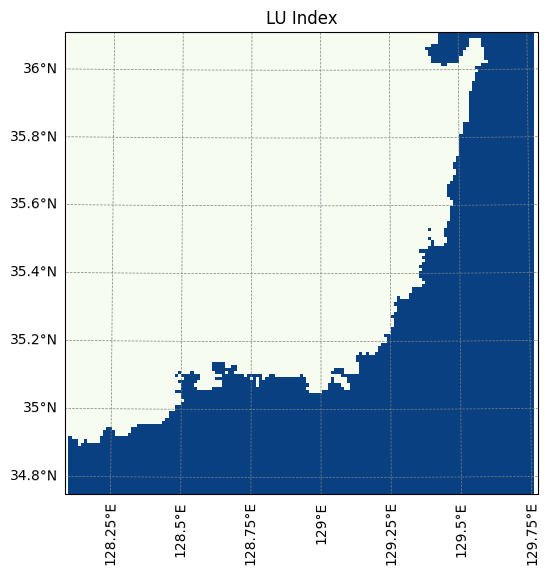

In [12]:
import xarray as xr

# 기존 도메인에서 도시 제거하기
ds_clear = ds.copy()

# 조건: LANDMASK가 1이면서 LU_INDEX가 13인 값
condition = (ds_clear['LANDMASK'] == 1) & (ds_clear['LU_INDEX'] == 13)
# 조건이 참이면 5로 바꾸고, 거짓이라면 값을 유지
ds_clear['LU_INDEX'] = xr.where(condition, 5, ds_clear['LU_INDEX'])
plot_map(ds_clear)

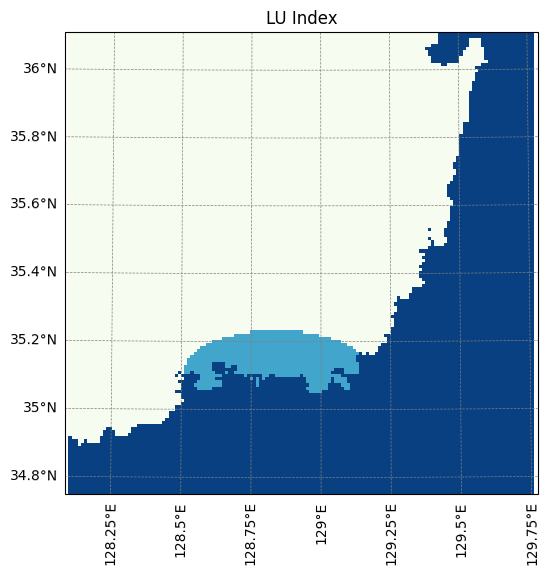

LU_INDEX가 13인 격자점의 개수: 725


In [84]:
# 1. 남쪽 해안에 도시 만들기 (geo_em.10.nc)
ds_south = ds_clear.copy()

import numpy as np
import xarray as xr

# --- 여기를 수정하여 타원의 모양과 위치를 설정하세요 ---

# 1. 중심 위도, 경도
center_lat = 35.115
center_lon = 128.84

# 2. 타원의 크기 (장축 반지름, 위/경도 단위로 근사)
semi_major_axis_km = 30.0  # 예: 장축 반지름 30km

# 3. 이심률 (0: 원, 1에 가까울수록 찌그러짐)
eccentricity = 0.9  # e

# 4. 회전 각도 (도 단위, 0: 동쪽, 90: 북쪽)
angle_degrees = 0.0

# --- 설정 끝 ---

# 타원의 장축/단축 반지름을 미터(m) 단위로 변환
semi_major_axis_m = semi_major_axis_km * 1000  # a
semi_minor_axis_m = semi_major_axis_m * np.sqrt(1 - eccentricity**2) # b

# 데이터셋의 모든 격자점의 위도와 경도 배열 가져오기
lats = ds_south['CLAT']
lons = ds_south['CLONG']

# 타원 중심의 위도를 기준으로 1도당 미터 거리 계산
# (정확한 계산을 위한 공식 사용)
m_per_deg_lat = 111132.954 - 559.822 * np.cos(2 * np.deg2rad(center_lat)) + 1.175 * np.cos(4 * np.deg2rad(center_lat))
m_per_deg_lon = 111319.491 * np.cos(np.deg2rad(center_lat))

# 1. 좌표계 변환: 중심으로부터의 '미터(m)' 거리 계산
x_m = (lons - center_lon) * m_per_deg_lon
y_m = (lats - center_lat) * m_per_deg_lat

# 2. 미터 좌표계에서 회전 변환 수행
angle_rad = np.deg2rad(angle_degrees)
cos_angle = np.cos(angle_rad)
sin_angle = np.sin(angle_rad)

x_rot_m = x_m * cos_angle + y_m * sin_angle
y_rot_m = -x_m * sin_angle + y_m * cos_angle

# 3. 미터 단위로 타원 마스크 생성
ellipse_mask = (x_rot_m / semi_major_axis_m)**2 + (y_rot_m / semi_minor_axis_m)**2 <= 1

# 4. 최종 조건 결합: (타원 내부) AND (LANDMASK == 1)
final_condition = ellipse_mask & (ds_south['LANDMASK'] == 1)

# 5. xr.where를 사용하여 조건에 맞는 지역의 LU_INDEX 값을 13으로 변경
ds_south['LU_INDEX'] = xr.where(final_condition, 13, ds_south['LU_INDEX'])

plot_map(ds_south)
count = (ds_south['LU_INDEX'] == 13).sum()
print((f"LU_INDEX가 13인 격자점의 개수: {count.item()}"))

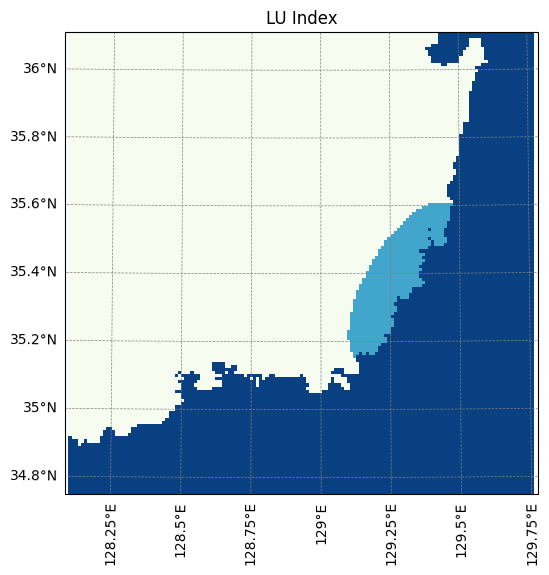

LU_INDEX가 13인 격자점의 개수: 705


In [83]:
# 2. 동쪽 해안에 도시 만들기 (geo_em.11.nc)
ds_east = ds_clear.copy()

import numpy as np
import xarray as xr

# --- 여기를 수정하여 타원의 모양과 위치를 설정하세요 ---

# 1. 중심 위도, 경도
center_lat = 35.37
center_lon = 129.305

# 2. 타원의 크기 (장축 반지름, 위/경도 단위로 근사)
semi_major_axis_km = 30.0  # 예: 장축 반지름 30km

# 3. 이심률 (0: 원, 1에 가까울수록 찌그러짐)
eccentricity = 0.9  # e

# 4. 회전 각도 (도 단위, 0: 동쪽, 90: 북쪽)
angle_degrees = 60.0

# --- 설정 끝 ---

# 타원의 장축/단축 반지름을 미터(m) 단위로 변환
semi_major_axis_m = semi_major_axis_km * 1000  # a
semi_minor_axis_m = semi_major_axis_m * np.sqrt(1 - eccentricity**2) # b

# 데이터셋의 모든 격자점의 위도와 경도 배열 가져오기
lats = ds_east['CLAT']
lons = ds_east['CLONG']

# 타원 중심의 위도를 기준으로 1도당 미터 거리 계산
# (정확한 계산을 위한 공식 사용)
m_per_deg_lat = 111132.954 - 559.822 * np.cos(2 * np.deg2rad(center_lat)) + 1.175 * np.cos(4 * np.deg2rad(center_lat))
m_per_deg_lon = 111319.491 * np.cos(np.deg2rad(center_lat))

# 1. 좌표계 변환: 중심으로부터의 '미터(m)' 거리 계산
x_m = (lons - center_lon) * m_per_deg_lon
y_m = (lats - center_lat) * m_per_deg_lat

# 2. 미터 좌표계에서 회전 변환 수행
angle_rad = np.deg2rad(angle_degrees)
cos_angle = np.cos(angle_rad)
sin_angle = np.sin(angle_rad)

x_rot_m = x_m * cos_angle + y_m * sin_angle
y_rot_m = -x_m * sin_angle + y_m * cos_angle

# 3. 미터 단위로 타원 마스크 생성
ellipse_mask = (x_rot_m / semi_major_axis_m)**2 + (y_rot_m / semi_minor_axis_m)**2 <= 1

# 4. 최종 조건 결합: (타원 내부) AND (LANDMASK == 1)
final_condition = ellipse_mask & (ds_east['LANDMASK'] == 1)

# 5. xr.where를 사용하여 조건에 맞는 지역의 LU_INDEX 값을 13으로 변경
ds_east['LU_INDEX'] = xr.where(final_condition, 13, ds_east['LU_INDEX'])

plot_map(ds_east)
count = (ds_east['LU_INDEX'] == 13).sum()
print((f"LU_INDEX가 13인 격자점의 개수: {count.item()}"))

In [85]:
# 다시 netCDF로 저장
ds_south_out = ds.copy()
ds_south_out['LU_INDEX'] = ds_south['LU_INDEX']

f_south = '/content/drive/MyDrive/UHI/geo_em.10.nc'
ds_south_out.to_netcdf(f_south)

ds_east_out = ds.copy()
ds_east_out['LU_INDEX'] = ds_east['LU_INDEX']

f_east = '/content/drive/MyDrive/UHI/geo_em.11.nc'
ds_east_out.to_netcdf(f_east)

/tmp/ipython-input-1728898083.py:6: UserWarning: Unlimited dimension(s) {'time'} declared in 'dataset.encoding', but not part of current dataset dimensions. Consider removing {'time'} from 'dataset.encoding'.
  ds_south_out.to_netcdf(f_south)
/tmp/ipython-input-1728898083.py:12: UserWarning: Unlimited dimension(s) {'time'} declared in 'dataset.encoding', but not part of current dataset dimensions. Consider removing {'time'} from 'dataset.encoding'.
  ds_east_out.to_netcdf(f_east)
